# **Experiment 1: Value Model Measurements**

1. **Workload Latencies**: Measure the response times of the system.
2. **Latency Prediction Q-Errors**: Evaluate the accuracy of the system's latency prediction model by calculating Q-Errors, which quantify the deviation between predicted and actual latencies.
3. **Inference Times**: Analyze the time taken for the system to process and generate predictions, providing insights into its computational efficiency.

### **Hardware Used**

| **System**                                      | **CPU**                                       | **RAM**                                      | **Storage**                                   | **GPU**                                          | **Platform**                                     |
|-------------------------------------------------|-----------------------------------------------|----------------------------------------------|-----------------------------------------------|-------------------------------------------------|-------------------------------------------------|
| **BAO**                                         | Intel Xeon Gold 6230                         | 15GB (VM) + 256GB (CPU)                      | Not specified                                 | Tesla T4 GPU                                     | Google Cloud Platform (N1-4 VM)                 |
| **LOGER**                                       | 2× Intel Xeon Gold                           | 256GB                                        | Not specified                                 | NVIDIA RTX 3090                                  | Physical Server                                 |
| **BALSA**                                       | Microsoft Azure VMs (8 cores)                | 64GB                                         | SSD                                           | NVIDIA Tesla M60 GPU                             | Microsoft Azure                                 |
| **FASTgres**                                    | Intel Xeon Gold 6216 (12 cores)              | 92GB                                         | 1.8 TiB storage                               | Not specified                                    | Physical Server                                 |
| **train-server (Hosts PostgreSQL)**             | QEMU Virtual CPU version 2.5                 | 110GB                                        | 2.0 TiB SSD                                   | None                                            | Physical Server                                 |
| **train-gpu-server (Hosts the optimizers)**     | Intel(R) Xeon(R) Gold 5318Y                  | 377GB                                        | 1.4 TiB SSD                                   | NVIDIA RTX A6000                                  | Physical Server                                 |

### **PostgreSQL Configurations**

| **PostgreSQL Config Parameter**  | **Description** | **Default Values** | **JOB** | **Bao** | **Balsa** | **LOGER** | **Our Framework** |
|----------------------------------|----------------|------------------|-------------|-------------|-----------------------|-------------|----------------|
| **Join Order** |  |  |  |  |  |  |  |
| geqo_threshold | Sets the threshold for Genetic Query Optimizer (GEQO) to be used | 12 | 18 |  |  | 2 or 1,024 |  |
| geqo | Enables or disables GEQO, which helps optimize complex queries | on |  |  | off | off | off |
| **Working Memory** |  |  |  |  |  |  |  |
| work_mem | Memory allocated for each query operation (e.g., sorting, hashing) | 4 MB | 2 GB |  | 4 GB | | 4 GB |
| shared_buffers | Memory used for PostgreSQL's buffer cache to reduce disk I/O | 128 MB | 4 GB | 4 GB | 32 GB | 64 GB | 32 GB |
| temp_buffers | Memory allocated for temporary tables during a session | 8 MB |  |  | 32 GB |  | 32 GB |
| effective_cache_size | Estimated memory available for caching disk pages | 4 GB | 32 GB |  |  |  | 64 GB |
| **Parallelization** |  |  |  |  |  |  |  |
| max_parallel_workers | Maximum number of parallel workers allowed | 8 |  |  |  | 1 | 8 |
| max_parallel_workers_per_gather | Maximum parallel workers per `Gather` node in a query plan | 8 |  |  |  | 1 | 8 |
| max_worker_processes | Maximum background worker processes allowed | 2 |  |  | 8 |  | 8 |
| **Scan Types** |  |  |  |  |  |  |  |
| enable_bitmapscan | Enables bitmap scans for efficient index-based retrieval | on |  | | off |  | on |
| enable_tidscan | Enables TID scans, which use tuple IDs for direct row lookups | on |  |  | off |  | on |


## **Benchmarks Used**

### **1. JOB and its Variants**

#### **Join Order Benchmark (Default)**

- Evaluates the efficiency of database query optimizers, focusing on join order optimization and cardinality estimation accuracy.
- 21 Tables, 6 Columns per Table on Average, 3.6 GB in size, 113 Queries in total, 8 average Joins per query

## **2. TPC-H and Its Variants**  

### **TPC-H-NO-NESTED-QUERIES**  
- Uses **templates 3, 5, 12, and 14** for training and **template 10** for testing, with **10 queries per template**.  
- Excludes queries containing **nested subqueries** in either the **FROM** or **WHERE** clause.  
- Templates **7, 8, and 13** are excluded due to their reliance on these nested structures, which **LOGER** and **FASTgres** cannot process.  
- **Example of Banned Queries:**  

  **1. Nested FROM Clause (Disallowed)**  
  ```sql
  SELECT o_orderkey, revenue
  FROM (
      SELECT l_orderkey AS o_orderkey, SUM(l_extendedprice) AS revenue
      FROM lineitem
      GROUP BY l_orderkey
  ) AS subquery
  WHERE revenue > 100000;
  ```
  - This query is excluded because it **uses a subquery in the FROM clause (nested FROM)**.  

  **2. Nested WHERE Clause (Disallowed)**  
  ```sql
  SELECT l_orderkey
  FROM lineitem
  WHERE l_extendedprice > (
      SELECT AVG(l_extendedprice)
      FROM lineitem
  );
  ```
  - This query is excluded because it **contains a subquery in the WHERE clause**.  

- **Compatible with:**  
  - BAO  
  - Balsa  
  - FASTgres  
  - LOGER  

### **3. TPC-DS**  

### **3.1 TPC-DS-SIMPLE** (originates from *LOGER*)
- Only queries in SPJ Format
- Uses **15 templates for training** and **5 templates for testing**, ensuring that all tables in the testing workload appear in the training workload.  
- Generates **3 queries per template** for both training and testing.  
- **Training Templates:** 3, 7, 12, 20, 26, 37, 42, 43, 50, 55, 62, 84, 91, 96, 99  
- **Testing Templates:** 18, 27, 52, 82, 98  
- **Compatible with:**
  - BAO
  - LOGER  
  - FASTgres (WIP)  


In [74]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from pathlib import Path
from tqdm import tqdm
import glob

OPTIMIZERS = ['BAO', 'LOGER', 'LERO', 'NEO']
# ==============================================================================
# 1. DATA COLLECTION
# ==============================================================================

def parse_checkpoint_name(name):
    epoch_match = re.search(r"epoch-?(\d+)", name)
    queries_match = re.search(r"queries-?(\d+)", name)
    loss_match = re.search(r"loss-?([-\d.e]+)", name)
    epoch = int(epoch_match.group(1)) if epoch_match else -1
    queries = int(queries_match.group(1)) if queries_match else -1
    loss = float(loss_match.group(1)) if loss_match else -1.0
    return epoch, queries, loss

def discover_checkpoints(models_base_dir, optimizer_name):
    """
    Discovers trained model checkpoints for a given optimizer.
    Keeps .pt, .pkl, and valid checkpoint directories.
    Excludes metadata, baselines, and final_model files.
    """
    checkpoint_list = []
    optimizer_path = Path(models_base_dir) / optimizer_name.upper()
    subdirs = ["epoch_checkpoints", "query_checkpoints", "loss_checkpoints"]

    unique_names = set()
    allowed_extensions = {".pt", ".pkl"}  # valid checkpoint files

    exclude_patterns = (
        "_metadata.json",
        "_metadata.txt",
        "_baseline.pkl",
    )

    for subdir in subdirs:
        full_subdir_path = optimizer_path / subdir
        if not full_subdir_path.is_dir():
            continue

        for item_path in full_subdir_path.iterdir():
            # --- case 1: valid file checkpoint ---
            if item_path.is_file():
                if item_path.suffix not in allowed_extensions:
                    continue
                if any(str(item_path).endswith(pattern) for pattern in exclude_patterns):
                    continue
                if item_path.stem.startswith("final_model"):
                    continue
                base_name = item_path.stem

            # --- case 2: valid directory checkpoint ---
            elif item_path.is_dir():
                # skip final_model dirs or metadata dirs
                if item_path.name.startswith("final_model"):
                    continue
                # heuristic: treat any directory without extension as checkpoint
                base_name = item_path.name

            else:
                continue

            # avoid duplicates
            if base_name not in unique_names:
                # print(f"Discovered checkpoint: {base_name}")
                # print(f"  Path: {item_path}")
                unique_names.add(base_name)
                # Filter out "_checkpoint" suffix if present
                if base_name.endswith("_checkpoint"):
                    base_name = base_name[: -len("_checkpoint")]
                checkpoint_list.append({
                    "name": base_name,
                    "type": subdir,
                    "path": str(item_path)
                })
    return checkpoint_list

In [75]:
def extract_execution_time(plan_json):
    try:
        if isinstance(plan_json, list) and isinstance(plan_json[-1], dict) and 'Execution Time' in plan_json[-1]:
            return plan_json[-1].get('Execution Time', 0.0)
        if isinstance(plan_json, list) and 'Execution Time' in plan_json[0]:
            return plan_json[0]['Execution Time']
        if isinstance(plan_json, list) and isinstance(plan_json[0], list) and 'Execution Time' in plan_json[-1][0][0]:
            return plan_json[0][0][0]['Execution Time']
        if isinstance(plan_json, dict) and 'Execution Time' in plan_json:
            return plan_json.get('Execution Time', 0.0)
    except (IndexError, KeyError, TypeError): pass
    return 0.0

def extract_planning_time(plan_json):
    try:
        if isinstance(plan_json, list) and isinstance(plan_json[-1], dict) and 'Planning Time' in plan_json[-1]:
            return plan_json[-1].get('Planning Time', 0.0)
        if isinstance(plan_json, list) and 'Planning Time' in plan_json[0]:
            return plan_json[0]['Planning Time']
        if isinstance(plan_json, list) and isinstance(plan_json[0], list) and 'Planning Time' in plan_json[-1][0][0]:
            return plan_json[0][0][0]['Planning Time']
        if isinstance(plan_json, dict) and 'Planning Time' in plan_json:
            return plan_json.get('Planning Time', 0.0)
    except (IndexError, KeyError, TypeError): pass
    return 0.0

def build_trajectory_df_from_files(discovered_checkpoints, results_base_dir, optimizer_name):
    rows = []
    for checkpoint in tqdm(discovered_checkpoints, desc=f"Processing {optimizer_name} Checkpoints"):
        name, type_dir = checkpoint['name'], checkpoint['type']
        pattern = Path(results_base_dir) / "*" / optimizer_name.upper() / type_dir / name / "**" / "*_plan.json"
        plan_files = glob.glob(str(pattern), recursive=True)
        if not plan_files: continue
        total_lat_ms, q_errors = 0, []
        for plan_path in plan_files:
            pred_lat_ms, exec_time_ms = np.nan, 0
            try:
                with open(plan_path, 'r') as f: plan_data = json.load(f)
                exec_time_ms = extract_execution_time(plan_data)
                planning_time_ms = extract_planning_time(plan_data)
                if exec_time_ms > 0: total_lat_ms += exec_time_ms
                if planning_time_ms > 0: total_lat_ms += planning_time_ms
                if optimizer_name.upper() == 'BAO':
                    if isinstance(plan_data, list) and len(plan_data) > 0 and 'Bao' in plan_data[0]:
                        pred_lat_ms = plan_data[0]['Bao'].get('Bao prediction', np.nan)
                else:
                    metrics_path = plan_path.replace('_plan.json', '_metrics.json')
                    if os.path.exists(metrics_path):
                        # print(f"Loading metrics from {metrics_path}")
                        with open(metrics_path, 'r') as f: metrics_data = json.load(f)
                        pred_lat_ms = metrics_data.get('predicted_latency_ms', np.nan)
                if exec_time_ms > 0 and not np.isnan(pred_lat_ms) and pred_lat_ms > 0:
                    if optimizer_name.upper() == 'NEO':
                        pred_lat_ms *= 10
                    q_errors.append(max(pred_lat_ms / exec_time_ms, exec_time_ms / pred_lat_ms))
            except Exception: continue
        if total_lat_ms == 0: continue
        rows.append({
            "optimizer": optimizer_name, "checkpoint_type": type_dir.replace("_checkpoints", ""),
            **dict(zip(["epoch", "queries_seen", "model_loss"], parse_checkpoint_name(name))),
            "cumulative_latency_s": total_lat_ms / 1000.0, "avg_q_error": np.mean(q_errors) if q_errors else np.nan
        })
    return pd.DataFrame(rows)   

def get_postgres_baseline(results_base_dir):
    # search_pattern = Path(results_base_dir) / "POSTGRES" / "**" / "*_plan.json"
    search_pattern = Path(results_base_dir) / "**" / "classic_qep.json"
    print(f"Searching for Postgres baseline plans in {search_pattern}")
    plan_files = glob.glob(str(search_pattern), recursive=True)
    if not plan_files: return None
    total_latency_ms = sum(extract_execution_time(json.load(open(p, 'r'))) for p in plan_files)
    return total_latency_ms / 1000.0 if total_latency_ms > 0 else None

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from matplotlib.transforms import Bbox
from matplotlib.ticker import ScalarFormatter # Import the specific formatter

from matplotlib.lines import Line2D

def plot_optimizer_grid(df_long, optimizer_name, output_dir, baseline_latency=None, smooth_window=5):
    """
    Generates a 2x3 master grid plot for a SINGLE optimizer.
    This version saves each individual subplot with its own legend and axis labels, but NO titles.
    The final master grid plot also has no titles.
    """
    print(f"\nGenerating grid plot for {optimizer_name}...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 30})
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    MIN_X_DISTANCE_PCT = 0.5
    col_order = ["Epochs", "Queries Seen", "Model Loss"]

    if optimizer_name == "LERO":
        df_long = df_long[df_long["Training Policy"] != "Model Loss"]

    palette = sns.color_palette("Purples", 6)

    g = sns.relplot(
        data=df_long, x="Progress Value", y="Metric Value",
        row="Metric", col="Training Policy", col_order=col_order,
        kind="line", marker="s", dashes=False, color=palette[4], label="Raw",
        facet_kws={'sharey': False, 'sharex': False}, height=4, aspect=1.5,
        lw=2.5, markersize=8 
    )
    g.set_titles('') 
    # Increase spacing between subplots
    g.fig.set_size_inches(30, 12)
    plt.subplots_adjust(hspace=1.8, wspace=3)
    g.fig.tight_layout(pad=2)
    g.fig.canvas.draw()
    renderer = g.fig.canvas.get_renderer()
    
    # --- Loop through each subplot to customize and save individually ---
    for (metric, policy), ax in g.axes_dict.items():
        subset = df_long[(df_long["Metric"] == metric) & (df_long["Training Policy"] == policy)]
        if subset.empty:
            continue

        subset = subset.sort_values("Progress Value").reset_index(drop=True)

        smooth_y = subset["Metric Value"].rolling(window=smooth_window, min_periods=1, center=True).mean()
        ax.plot(subset["Progress Value"], smooth_y,
                color=palette[3], lw=2, alpha=0.9, label="Smoothed", linestyle='--',
                marker=None, zorder=2)
        
        if ax.lines:
            ax.lines[0].set_zorder(3)

        ax.grid(which="major", axis="both", linestyle="--", alpha=0.4)
        sns.despine(ax=ax)

        ax.set_xlabel(f"", fontsize=20)
        ax.set_ylabel("", fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.ticklabel_format(style='plain', axis='x')
        # # ### IMPROVEMENT: Conditional X-axis formatting ###
        # if policy == "Queries Seen":
        #     formatter = ScalarFormatter(useMathText=True)
        #     formatter.set_scientific(True)
        #     formatter.set_powerlimits((0, 0)) # Forces scientific notation
        #     ax.xaxis.set_major_formatter(formatter)
        # else:
        #     ax.ticklabel_format(style='plain', axis='x')
        
        ax.ticklabel_format(style='plain', axis='y')
        
        if metric == 'Workload Latency (s)' and baseline_latency is not None and optimizer_name != "NEO":
            ax.axhline(baseline_latency, ls='--', color='red', lw=1.5, label='PostgreSQL Baseline')
        
        if policy == "Model Loss":
            ax.invert_xaxis()
        
        ax.set_title('')
        
        sanitized_metric = str(metric).replace(' ', '_').replace('/', '_')
        sanitized_policy = str(policy).replace(' ', '_').replace('/', '_')
        subplot_filename = f"subplot_{optimizer_name}_{sanitized_metric}_{sanitized_policy}.pdf"
        subplot_filepath = Path(output_dir) / subplot_filename
        
        bbox_display = ax.get_tightbbox(renderer)
        bbox_inches = bbox_display.transformed(g.fig.dpi_scale_trans.inverted())
        g.fig.savefig(subplot_filepath, bbox_inches=bbox_inches)
        print(f"  - Saved subplot: {subplot_filename}")

    if optimizer_name == "LERO":
        g.fig.delaxes(g.axes[0][2])
        if len(g.axes) > 1:
            for ax in g.axes[1]:
                g.fig.delaxes(ax)

    filename = f"trajectory_grid_{optimizer_name}.pdf"
    plt.savefig(Path(output_dir) / filename, bbox_inches='tight')
    plt.show()
    print(f"Saved master plot: {filename}")

In [77]:
# --- Configuration ---
MODELS_BASE_DIR = '/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/models/experiment3'
RESULTS_BASE_DIR = '/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment3/test/'
OUTPUT_DIR = '/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment3/plots'
OPTIMIZERS = ['BAO', 'LOGER', 'LERO', 'NEO']

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Step 1: Consolidate data ---
all_trajectories = []
for optimizer in OPTIMIZERS:
    print(f"\n--- Processing Data for: {optimizer} ---")
    discovered = discover_checkpoints(MODELS_BASE_DIR, optimizer)
    if not discovered:
        print(f"No checkpoints found for {optimizer}. Skipping.")
        continue
    
    df = build_trajectory_df_from_files(discovered, RESULTS_BASE_DIR, optimizer)
    if not df.empty:
        all_trajectories.append(df)

if not all_trajectories:
    print("No data collected for any optimizer. Exiting.")
    exit()

master_df = pd.concat(all_trajectories, ignore_index=True)
pg_baseline_latency = get_postgres_baseline(RESULTS_BASE_DIR)
# MODIFICATION: We still calculate the baseline, just don't plot it for now.
# This makes it easy to re-enable later.
if pg_baseline_latency:
    print(f"\nPostgreSQL Baseline Latency (for reference): {pg_baseline_latency:.2f}s")
else:
    print("\nPostgreSQL baseline results not found.")


# --- Step 2: Reshape data from wide to long format for FacetGrid plotting ---
print("\nReshaping data for master plot...")
dfs_to_concat = []
policy_map = {
    'epoch': ('Epochs', 'epoch'),
    'query': ('Queries Seen', 'queries_seen'),
    'loss': ('Model Loss', 'model_loss')
}
for policy_short, (policy_long, col_name) in policy_map.items():
    df_policy = master_df[master_df['checkpoint_type'] == policy_short].copy()
    # Filter out placeholder values like -1
    df_policy = df_policy[df_policy[col_name] >= 0] 
    
    df_lat = df_policy[['optimizer', col_name, 'cumulative_latency_s']].rename(columns={
        col_name: 'Progress Value', 'cumulative_latency_s': 'Metric Value'
    })
    df_lat['Training Policy'] = policy_long
    df_lat['Metric'] = 'Workload Latency (s)'
    
    df_qerr = df_policy[['optimizer', col_name, 'avg_q_error']].rename(columns={
        col_name: 'Progress Value', 'avg_q_error': 'Metric Value'
    })
    df_qerr['Training Policy'] = policy_long
    df_qerr['Metric'] = 'Average Q-Error'
    
    dfs_to_concat.extend([df_lat, df_qerr])

long_df = pd.concat(dfs_to_concat, ignore_index=True).dropna()
long_df = long_df.sort_values(by=['optimizer', 'Training Policy', 'Progress Value'])


--- Processing Data for: BAO ---


Processing BAO Checkpoints: 100%|██████████| 40/40 [00:01<00:00, 28.83it/s]



--- Processing Data for: LOGER ---


Processing LOGER Checkpoints: 100%|██████████| 47/47 [00:01<00:00, 36.88it/s]



--- Processing Data for: LERO ---


Processing LERO Checkpoints: 100%|██████████| 46/46 [00:00<00:00, 47.64it/s]



--- Processing Data for: NEO ---


Processing NEO Checkpoints: 100%|██████████| 82/82 [00:01<00:00, 42.86it/s]


Searching for Postgres baseline plans in /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment3/test/**/classic_qep.json

PostgreSQL Baseline Latency (for reference): 178.98s

Reshaping data for master plot...


In [78]:
from matplotlib.lines import Line2D

def create_standalone_legend(output_dir, baseline_exists=True):
    """
    Creates and saves a standalone horizontal legend as a PDF.
    """
    print("\nGenerating standalone legend...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 20}) # Match legend font size

    palette = sns.color_palette("Purples", 6)

    # Define the elements that will appear in the legend (handles)
    legend_elements = [
        Line2D([0], [0], color=palette[4], lw=2.5, marker='s', markersize=8, label='Raw'),
        Line2D([0], [0], color=palette[3], lw=2, linestyle='--', label='Smoothed')
    ]

    if baseline_exists:
        legend_elements.append(
            Line2D([0], [0], color='red', lw=1.5, linestyle=':', label='PostgreSQL Baseline')
        )
        # Adjust the number of columns based on whether the baseline exists
        num_columns = 3
    else:
        num_columns = 2

    # Create a new figure and axis, but we will make them invisible
    fig, ax = plt.subplots()
    ax.axis('off') # Turn off the axis box, ticks, etc.

    # Create the legend
    legend = fig.legend(
        handles=legend_elements,
        loc='center',       # Center the legend on the figure
        ncol=num_columns,
        frameon=False       # Remove the frame around the legend
    )

    # Save the figure, cropping to only the legend's bounding box
    legend_path = Path(output_dir) / f"standalone_legend_{'baseline' if baseline_exists else 'no_baseline'}.pdf"
    fig.savefig(
        legend_path,
        bbox_inches='tight',
        bbox_extra_artists=[legend]
    )
    plt.close(fig) # Close the figure to free up memory
    print(f"Saved standalone legend to: {legend_path}")


# ==============================================================================
# 2. PLOTTING
# ==============================================================================
create_standalone_legend(OUTPUT_DIR, baseline_exists=True)
create_standalone_legend(OUTPUT_DIR, baseline_exists=False)


Generating standalone legend...
Saved standalone legend to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment3/plots/standalone_legend_baseline.pdf

Generating standalone legend...
Saved standalone legend to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment3/plots/standalone_legend_no_baseline.pdf



Generating grid plot for BAO...
  - Saved subplot: subplot_BAO_Workload_Latency_(s)_Epochs.pdf
  - Saved subplot: subplot_BAO_Workload_Latency_(s)_Queries_Seen.pdf
  - Saved subplot: subplot_BAO_Workload_Latency_(s)_Model_Loss.pdf
  - Saved subplot: subplot_BAO_Average_Q-Error_Epochs.pdf
  - Saved subplot: subplot_BAO_Average_Q-Error_Queries_Seen.pdf
  - Saved subplot: subplot_BAO_Average_Q-Error_Model_Loss.pdf


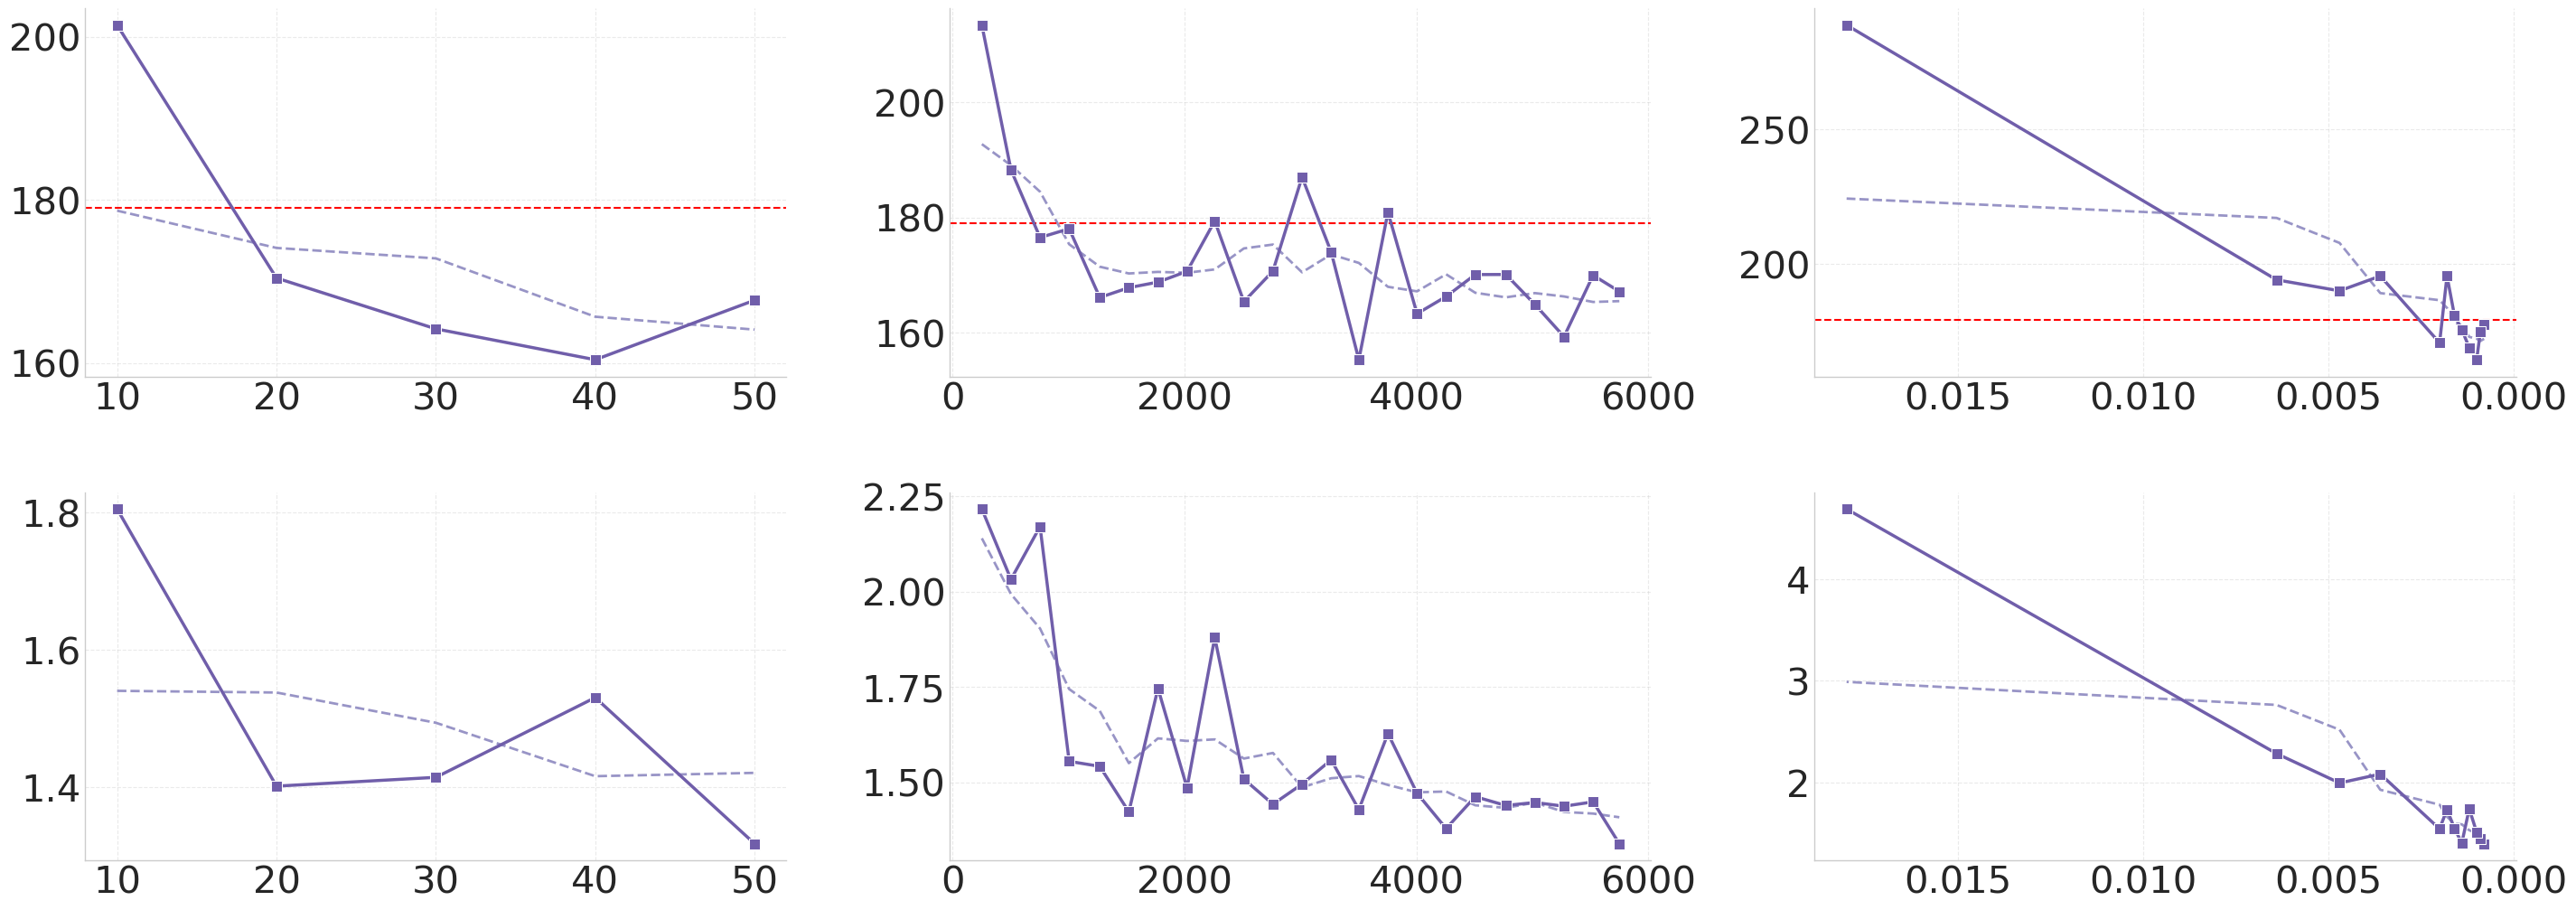

Saved master plot: trajectory_grid_BAO.pdf


In [79]:
optimizer_name = "BAO"
df_single_optimizer = long_df[long_df['optimizer'] == optimizer_name]
if optimizer_name == "LERO":
    df_single_optimizer = df_single_optimizer[df_single_optimizer['Training Policy'] != "Model Loss"]
if optimizer_name == "BAO":
    long_df.loc[(long_df['optimizer'] == 'BAO') & (long_df['Training Policy'] == 'Model Loss'), 'Progress Value'] *= 1000
if not df_single_optimizer.empty:
    plot_optimizer_grid(
        df_single_optimizer,
        optimizer_name,
        OUTPUT_DIR,
        pg_baseline_latency
    )

**BAO**

- Epoch-based Training:
  - Some signs of overfitting at the end of the curve with the latency regressing
  - The moment the workload latency hits its lowest point, the Q-Error has actually hit a local maximum, suggesting that Q-Error is not the only metric that should be accounted for when tracking learning progress, but rather a component of the tracking
- Queries seen policy actually demonstrates many spikes
- Loss-based training showed the most linear trajectory out of every counterpart, seems to be the best metric for BAO's training module


Generating grid plot for LOGER...
  - Saved subplot: subplot_LOGER_Workload_Latency_(s)_Epochs.pdf
  - Saved subplot: subplot_LOGER_Workload_Latency_(s)_Queries_Seen.pdf
  - Saved subplot: subplot_LOGER_Workload_Latency_(s)_Model_Loss.pdf
  - Saved subplot: subplot_LOGER_Average_Q-Error_Epochs.pdf
  - Saved subplot: subplot_LOGER_Average_Q-Error_Queries_Seen.pdf
  - Saved subplot: subplot_LOGER_Average_Q-Error_Model_Loss.pdf


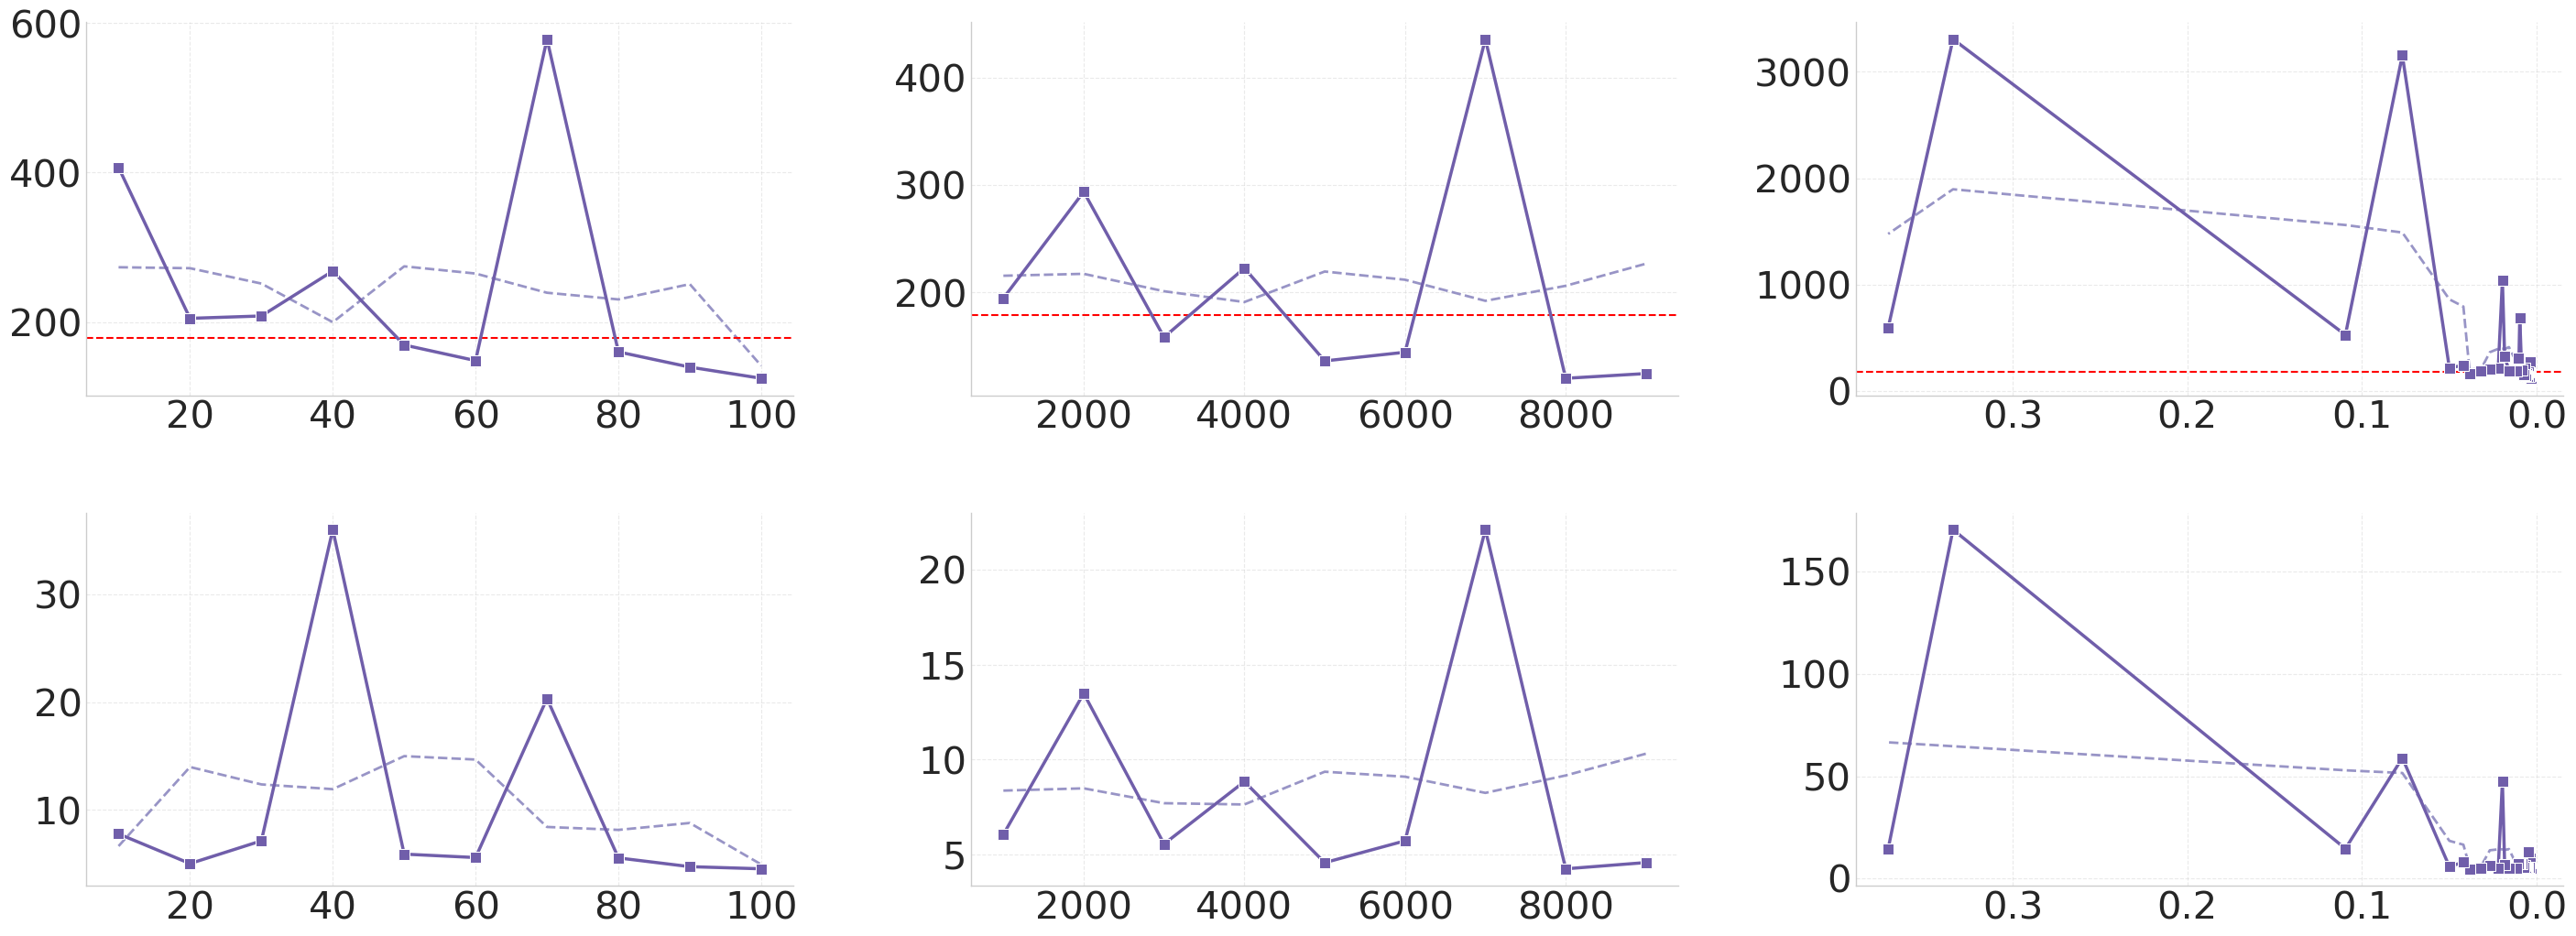

Saved master plot: trajectory_grid_LOGER.pdf


In [80]:
optimizer_name = "LOGER"
df_single_optimizer = long_df[long_df['optimizer'] == optimizer_name]
if optimizer_name == "LERO":
    df_single_optimizer = df_single_optimizer[df_single_optimizer['Training Policy'] != "Model Loss"]    
if not df_single_optimizer.empty:
    plot_optimizer_grid(
        df_single_optimizer,
        optimizer_name,
        OUTPUT_DIR,
        pg_baseline_latency
    )

**LOGER**

- More susceptible to wide margin regressions during training, across all 3 training paradigms
- Here average Q-Error seems to be a lot better at indicating training progress, as latency local minima map with q-error local minima, and also vice versa about the maxima
- This probably happens because of the Tree-LSTM & GT architecture that structures the embedding space in a better way
- (We still need to find a module that works best for LOGER)

Data points for NEO: 162

Generating grid plot for NEO...
  - Saved subplot: subplot_NEO_Workload_Latency_(s)_Epochs.pdf
  - Saved subplot: subplot_NEO_Workload_Latency_(s)_Queries_Seen.pdf
  - Saved subplot: subplot_NEO_Workload_Latency_(s)_Model_Loss.pdf
  - Saved subplot: subplot_NEO_Average_Q-Error_Epochs.pdf
  - Saved subplot: subplot_NEO_Average_Q-Error_Queries_Seen.pdf
  - Saved subplot: subplot_NEO_Average_Q-Error_Model_Loss.pdf


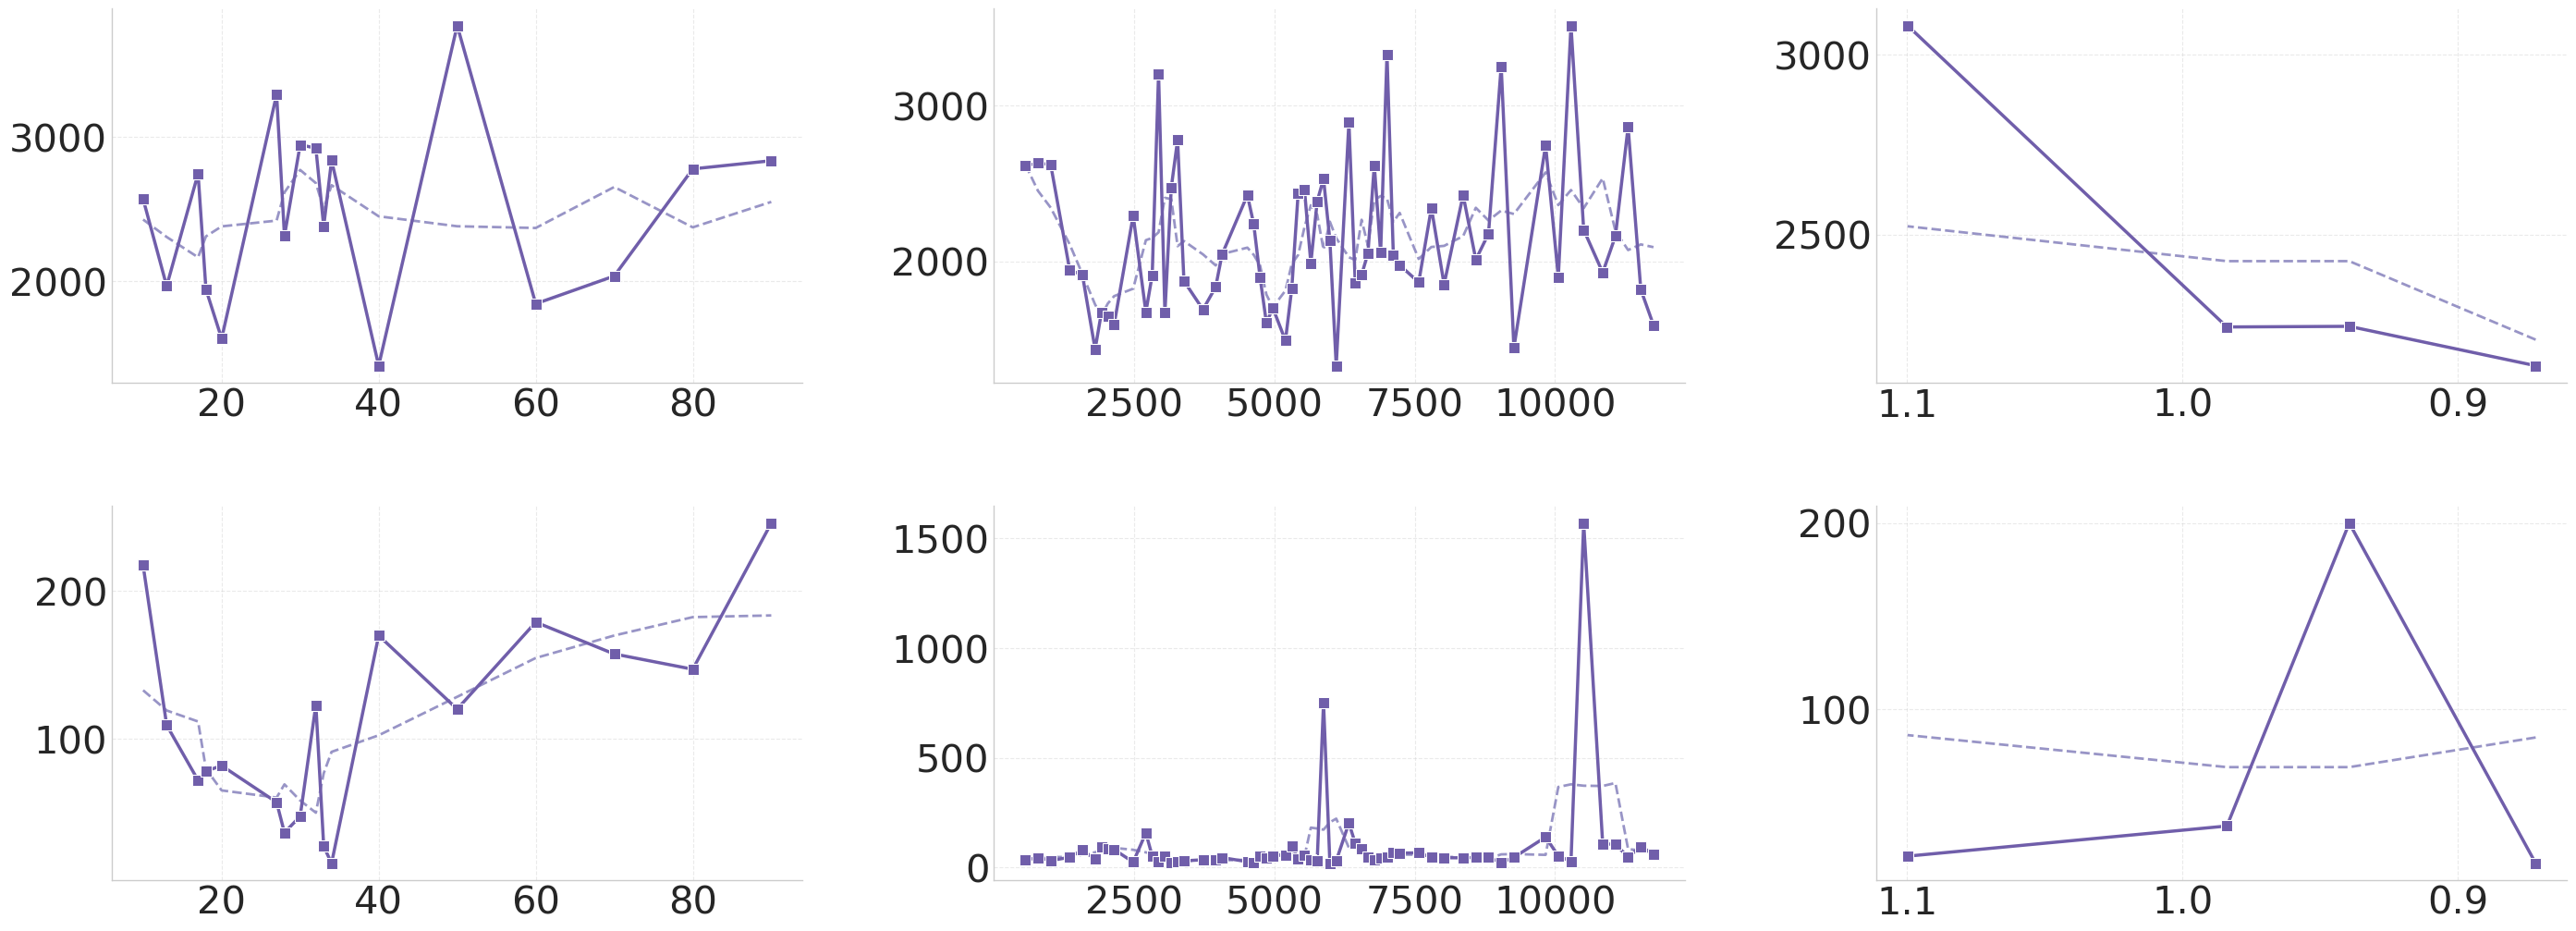

Saved master plot: trajectory_grid_NEO.pdf


In [81]:
optimizer_name = "NEO"
df_single_optimizer = long_df[long_df['optimizer'] == optimizer_name]
print(f"Data points for {optimizer_name}: {len(df_single_optimizer)}")
if optimizer_name == "LERO":
    df_single_optimizer = df_single_optimizer[df_single_optimizer['Training Policy'] != "Model Loss"]
if not df_single_optimizer.empty:
    plot_optimizer_grid(
        df_single_optimizer,
        optimizer_name,
        OUTPUT_DIR,
        pg_baseline_latency
    )
else:
    print(f"No data available for optimizer: {optimizer_name}")

**NEO**

- Loss-related checkpoints are very minute because the network never went below the 0.93 training loss mark
- So many spikes cause the optimizer does not converge to sound optimization policies
- The fact that the Model does not converge in terms of training loss explains every behavior we have seen from NEO so far


Generating grid plot for LERO...
  - Saved subplot: subplot_LERO_Workload_Latency_(s)_Epochs.pdf
  - Saved subplot: subplot_LERO_Workload_Latency_(s)_Queries_Seen.pdf
  - Saved subplot: subplot_LERO_Average_Q-Error_Epochs.pdf
  - Saved subplot: subplot_LERO_Average_Q-Error_Queries_Seen.pdf


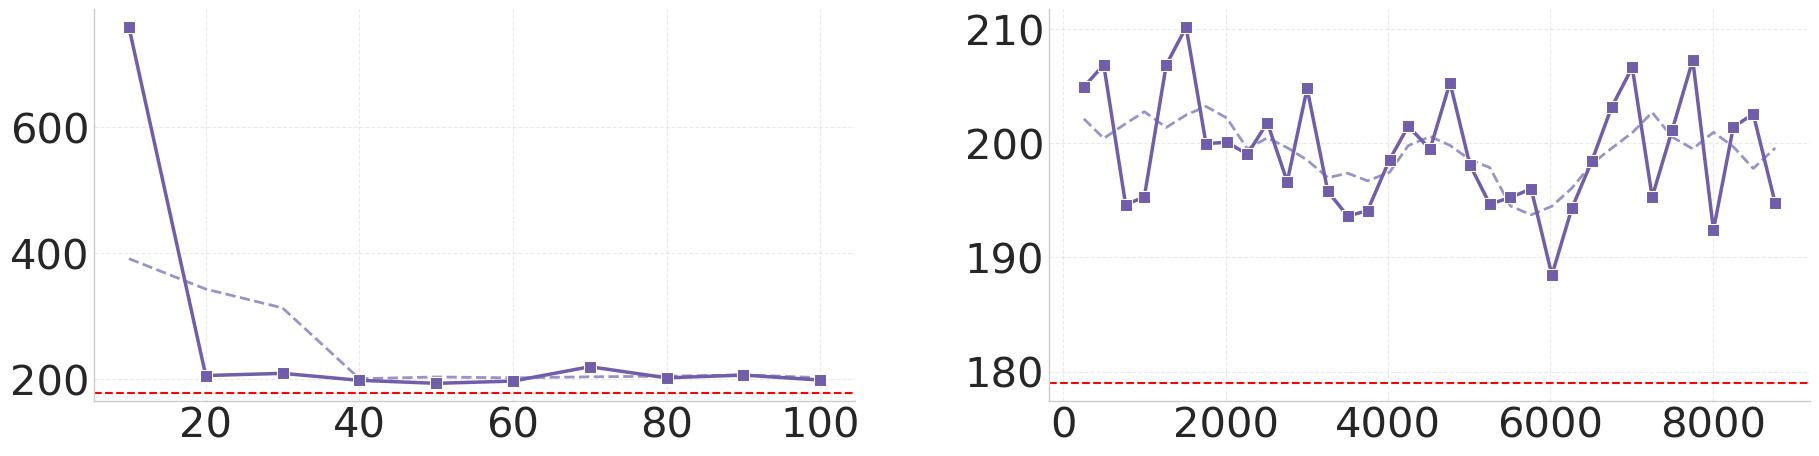

Saved master plot: trajectory_grid_LERO.pdf


In [82]:
optimizer_name = "LERO"
df_single_optimizer = long_df[long_df['optimizer'] == optimizer_name]
if optimizer_name == "LERO":
    df_single_optimizer = df_single_optimizer[df_single_optimizer['Training Policy'] != "Model Loss"]    
if not df_single_optimizer.empty:
    plot_optimizer_grid(
        df_single_optimizer,
        optimizer_name,
        OUTPUT_DIR,
        pg_baseline_latency
    )

- Training Loss plots were not included because the TCNN's utility in this context is different. 
- Its task it to compare plans with oneanother and determine which of the alternatives is better, The loss stems from whether the Value Model guessed correctly, so it is not a matter of predicting latency rather than relative performance. 
- Thus the training loss does not fluctuate as the fit keeps returning a ln(2) training loss between the plans
- Also for the reasons above, analysis of prediction Q-Error does not apply